In [1]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = "PlantVillage"

In [8]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.


In [10]:
val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.
Using 3202 files for validation.


In [11]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Data augmentation (Optional but helpful)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [12]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

In [13]:
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model = models.Sequential([
    data_augmentation,  # Apply data augmentation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # You can increase this value to improve results
    callbacks=[early_stopping]
)

Epoch 1/20
801/801 [==============================] - 499s 623ms/step - loss: 0.1860 - accuracy: 0.9338 - val_loss: 0.1192 - val_accuracy: 0.9603
Epoch 2/20
801/801 [==============================] - 538s 672ms/step - loss: 0.1847 - accuracy: 0.9377 - val_loss: 0.2172 - val_accuracy: 0.9197
Epoch 3/20
801/801 [==============================] - 487s 608ms/step - loss: 0.1851 - accuracy: 0.9389 - val_loss: 0.1916 - val_accuracy: 0.9394
Epoch 4/20
801/801 [==============================] - 476s 595ms/step - loss: 0.1698 - accuracy: 0.9445 - val_loss: 0.1885 - val_accuracy: 0.9450
Epoch 5/20
801/801 [==============================] - 489s 611ms/step - loss: 0.1739 - accuracy: 0.9437 - val_loss: 0.2305 - val_accuracy: 0.9260
Epoch 6/20
801/801 [==============================] - 496s 619ms/step - loss: 0.1822 - accuracy: 0.9398 - val_loss: 0.1176 - val_accuracy: 0.9572
Epoch 7/20
801/801 [==============================] - 515s 643ms/step - loss: 0.1617 - accuracy: 0.9472 - val_loss: 0.1358 -

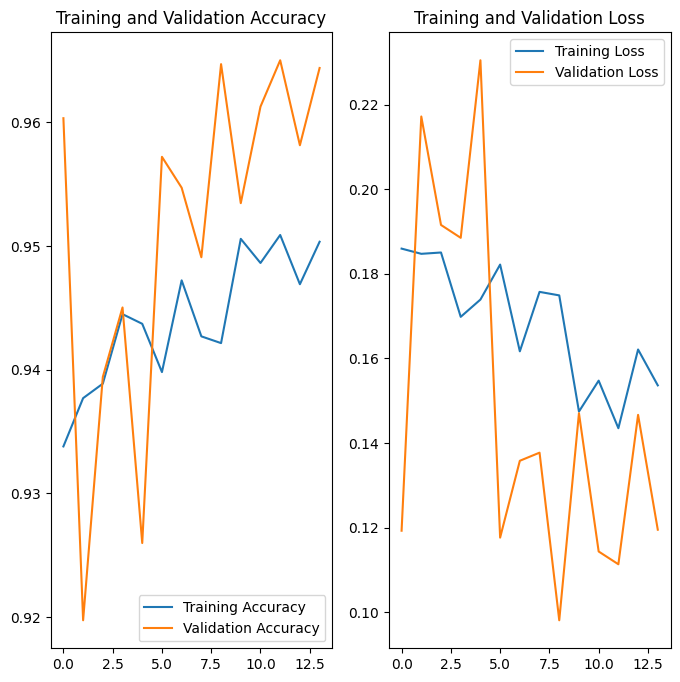

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.save("tomato_disease_model")

INFO:tensorflow:Assets written to: tomato_disease_model\assets


INFO:tensorflow:Assets written to: tomato_disease_model\assets
